1. 뉴스 데이터 : 매체, 제목, 날짜, 본문, 작성시간, url
2. 뉴스 별 댓글 데이터 :

# 1. 네이버뉴스 - 언론사 list 추출

In [1]:
#lib import
import requests
from bs4 import BeautifulSoup
import re
from datetime import date, timedelta
import json

## 1-1 언론사별 랭킹뉴스 > 댓글 많은 뉴스 URL에서 크롤링 시작

https://news.naver.com/main/ranking/popularMemo.naver?date=20220427

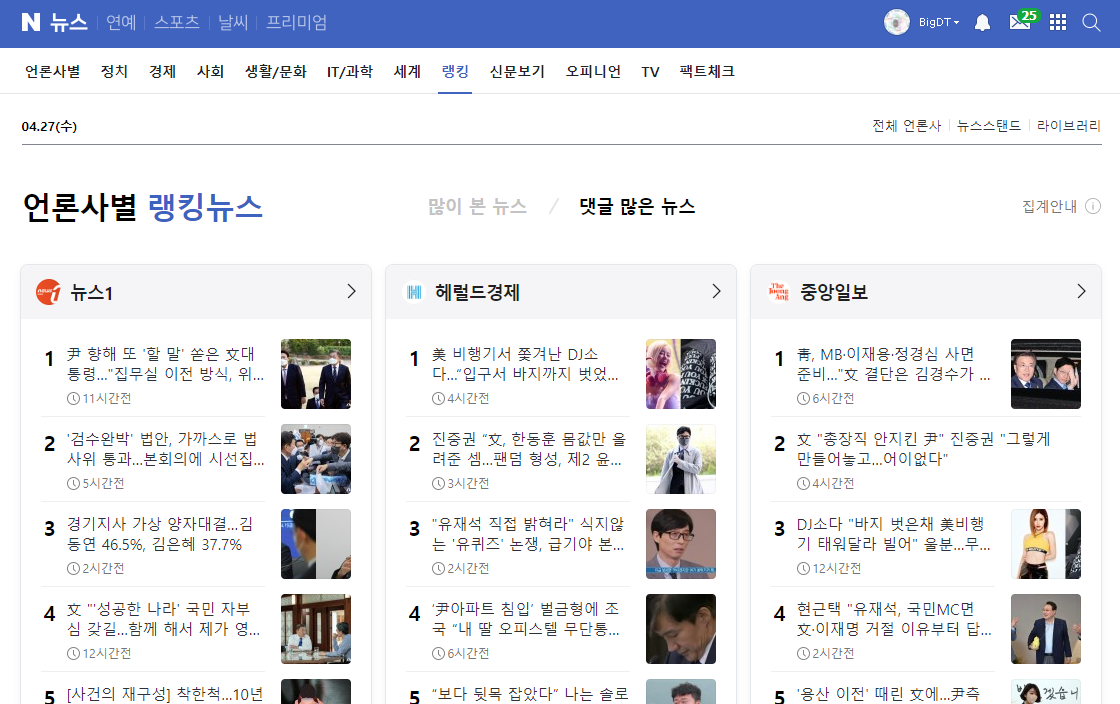

In [2]:
url = "https://news.naver.com/main/ranking/popularMemo.naver?date=20220427"

In [3]:
#URL headers 등록

#해당 site의 user-agent 확인.
#위치 : F12 -> Network -> Headers
headers = {
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"
}
res = requests.get(url,headers = headers)

In [4]:
#상태값 확인 -> 200 : 성공 응답
res.status_code

200

In [ ]:
#Beautifulsoup으로 URL 구성하고 있는 html 전체 긁어오기

soup = BeautifulSoup(res.text,'lxml') #lxml 파서 사용하는이유? 제일 빨라서
print(soup)
#참고: https://randomtip.tistory.com/26

##### 참고
부모 자식 관계는 space

직속 관계면 > 

select 하면 list형태로 나옴.

## 1-2 Card0에 해당하는 부분만 추출해보기(continue Card12,24,36....)

In [6]:
#officeCard0에 해당하는 언론사 list,url 추출
lis = soup.select("div._officeCard._officeCard0 > div")
for li in lis:
    url = li.select("a")[0]["href"]
    txt = li.select("a > strong.rankingnews_name")[0].text
    print(txt,url)

아시아경제 https://media.naver.com/press/277/ranking?type=comment
연합뉴스 https://media.naver.com/press/001/ranking?type=comment
파이낸셜뉴스 https://media.naver.com/press/014/ranking?type=comment
YTN https://media.naver.com/press/052/ranking?type=comment
JTBC https://media.naver.com/press/437/ranking?type=comment
매일경제 https://media.naver.com/press/009/ranking?type=comment
중앙일보 https://media.naver.com/press/025/ranking?type=comment
한국일보 https://media.naver.com/press/469/ranking?type=comment
KBS https://media.naver.com/press/056/ranking?type=comment
조선일보 https://media.naver.com/press/023/ranking?type=comment
헤럴드경제 https://media.naver.com/press/016/ranking?type=comment
한겨레 https://media.naver.com/press/028/ranking?type=comment


## 1-3 모든 언론사 list 추출
- Naver 뉴스에는 총 77개의 언론사가 있다.

In [7]:
#officeCard0~ 마지막까지 다 뽑아내야지
lis_num = 1 #언론사 count 변수
lis = soup.find_all("div",{"class":re.compile('^_officeCard _officeCard\d')})
for li in lis:  
    li_inner = li.select("div.rankingnews_box")
    print("###########################################################################")
    for at in li_inner:        
        txt = at.select("strong.rankingnews_name")[0].text
        url = at.select("a")[0]["href"]
        print(lis_num,txt,url)
        lis_num +=1
    

###########################################################################
1 아시아경제 https://media.naver.com/press/277/ranking?type=comment
2 연합뉴스 https://media.naver.com/press/001/ranking?type=comment
3 파이낸셜뉴스 https://media.naver.com/press/014/ranking?type=comment
4 YTN https://media.naver.com/press/052/ranking?type=comment
5 JTBC https://media.naver.com/press/437/ranking?type=comment
6 매일경제 https://media.naver.com/press/009/ranking?type=comment
7 중앙일보 https://media.naver.com/press/025/ranking?type=comment
8 한국일보 https://media.naver.com/press/469/ranking?type=comment
9 KBS https://media.naver.com/press/056/ranking?type=comment
10 조선일보 https://media.naver.com/press/023/ranking?type=comment
11 헤럴드경제 https://media.naver.com/press/016/ranking?type=comment
12 한겨레 https://media.naver.com/press/028/ranking?type=comment
###########################################################################
13 오마이뉴스 https://media.naver.com/press/047/ranking?type=comment
14 SBS https://media.naver.com/press

# 2. 언론사 별 뉴스 기사 가져오기(Rank 20까지)

## 2-1 언론사 1개의 뉴스 기사 가져와보기(Test)

-당일 기준이고  
네이버의 경우.. 동적 웹페이지인데(날자 바꿔도 url 바뀌지 않음)  
이 경우 동적 웹페이지 크롤링을 lib 써야함

-동적 웹페이지 크롤링(Selenium) 안써도 되는 방법 찾음!!! <br>
https://blog.naver.com/yundongcheol/220606742182  

예시 : https://media.naver.com/press/449/ranking?type=popular&date=20220420

In [8]:
#날짜 추출
from datetime import date, timedelta

today = date.today()
yesterday = date.today() - timedelta(1)
 
print(today.strftime('%Y%m%d')) #오늘
print(yesterday.strftime('%Y%m%d')) #어제

today = today.strftime('%Y%m%d')
yesterday = yesterday.strftime('%Y%m%d')

20220512
20220511


In [9]:
# 연합뉴스 랭킹 뉴스 기사 크롤링
#https://media.naver.com/press/055/ranking?type=comment

url2 = "https://media.naver.com/press/055/ranking?type=comment&date=" + str(yesterday) #headers 동일
res2 = requests.get(url2, headers=headers)
soup2 = BeautifulSoup(res2.text, 'lxml')
#soup2

#### HTML 구조파악
26일  
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(1) > a > div.list_content > strong   
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(2) > a > div.list_content > strong  
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(6) > a > div.list_content > strong  
ct > div.press_ranking_home > div:nth-child(4) > ul > li:nth-child(1) > a > div.list_content > strong  
        
        
25일  
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(1) > a > div.list_content > strong

In [10]:
#Test - 하나만 뽑아보기
newslist = soup2.select("div.press_ranking_home ul>li.as_thumb")
rn = newslist[0].select("em.list_ranking_num")[0].text
news_title = newslist[0].select("strong.list_title")[0].text
news_url= newslist[0].select("a")[0]["href"]
print(rn,news_title,news_url)

1 [Pick] "출소 후 변호사 되고 싶다"…'아동 성 착취' 최찬욱 감형 호소 https://n.news.naver.com/article/055/0000972554?ntype=RANKING


In [11]:
#(랭킹 20위) 뉴스 전체 다 뽑기(댓글 많은 순)
for li in newslist:
    rn = li.select("em.list_ranking_num")[0].text
    news_title = li.select("strong.list_title")[0].text
    news_url= li.select("a")[0]["href"]
    print(rn,news_title,news_url)

1 [Pick] "출소 후 변호사 되고 싶다"…'아동 성 착취' 최찬욱 감형 호소 https://n.news.naver.com/article/055/0000972554?ntype=RANKING
2 [영상] 오징어 맨발로 밟아대고 주물럭…1분 영상에 난리 났다 https://n.news.naver.com/article/055/0000972511?ntype=RANKING
3 고성 오간 한동훈 청문회…민주당 의원 '황당 질의' 실소 https://n.news.naver.com/article/055/0000972322?ntype=RANKING
4 [Pick] "중앙선 넘어 주차 후 짜장면 먹으러 간 일가족…과태료 참교육" https://n.news.naver.com/article/055/0000972471?ntype=RANKING
5 [비디오머그] 이게 '생일빵'이었다고? 제보자 분노하게 만든 집단폭행 중학생들 https://n.news.naver.com/article/055/0000972297?ntype=RANKING
6 송영길, 오세훈 'TV토론 거부'에 "뭐가 두려워서 피하나" https://n.news.naver.com/article/055/0000972564?ntype=RANKING
7 이재명, 방탄용 출마 지적에 "잘못한 게 없으면 걱정할 일도 없다" https://n.news.naver.com/article/055/0000972503?ntype=RANKING
8 소상공인-자영업자 370만 명에 600만 원+α…당정 합의 https://n.news.naver.com/article/055/0000972430?ntype=RANKING
9 이준석, 백령도 해병부대서 "200만 원 공약 완전히 못 지켜 사과" https://n.news.naver.com/article/055/0000972509?ntype=RANKING
10 김건희 여사, 사실상 첫 공식 등장…본격 행보 시작하나 https://n.news.naver.com/article/055/0000972299?

## 2-2 언론사별 랭킹 뉴스 모두 추출
- 최종 코드

In [ ]:
#날짜 추출
today = date.today()
today = today.strftime('%Y%m%d')
yesterday = date.today() - timedelta(1)
yesterday = yesterday.strftime('%Y%m%d')

#크롤링 시작할 URL
url = "https://news.naver.com/main/ranking/popularMemo.naver?date="+ str(yesterday) 
headers = {
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"
}
res = requests.get(url,headers = headers)
soup = BeautifulSoup(res.text,'lxml')

total=[] #결과값 받을 list
lis = soup.find_all("div",{"class":re.compile('^_officeCard _officeCard\d')}) #_officeCard _officeCard숫자 모두 추출-> list 반환
for li in lis:  
    li_inner = li.select("div.rankingnews_box")    
    for at in li_inner:        
        txt = at.select("strong.rankingnews_name")[0].text
        url = at.select("a")[0]["href"]
        
        #언론사별 뉴스 리스트 추출 for 문
        url2 = url
        res2 = requests.get(url2, headers=headers)
        soup2 = BeautifulSoup(res2.text, 'lxml')        
        newslist = soup2.select("div.press_ranking_home ul>li.as_thumb")
        for li in newslist:
            rn = li.select("em.list_ranking_num")[0].text
            news_title = li.select("strong.list_title")[0].text
            news_url= li.select("a")[0]["href"]
            total.append({
                "date" : yesterday,
                "press" : txt,
                "ranking" : rn,
                "news_title" : news_title,
                "news_url" : news_url
            })
            print(yesterday,rn,txt,news_title,news_url)

In [13]:
import pandas as pd
df_Naver_NewsList= pd.DataFrame(total)


#csv로 저장
name = "Naver_NewsList_" + yesterday + ".csv"
#df.to_csv(name, mode='w')
df_Naver_NewsList.to_csv(name,index=False,encoding='utf-8-sig')

In [14]:
df_Naver_NewsList

,date,press,ranking,news_title,news_url
0,20220511,KBS,1,김성회 “조선 여성 절반 성노리개…우리 꼬라지 알고 분노해야”,https://n.news.naver.com/article/056/001126436...
1,20220511,KBS,2,“월급이 천만 원 밖에 안돼요”…日 국회의장 발언 여론 뭇매,https://n.news.naver.com/article/056/001126478...
2,20220511,KBS,3,"[단독] ‘혐오 논란’ 김성회, KBS 보도 반박…확인 결과 또 ‘허위’",https://n.news.naver.com/article/056/001126486...
3,20220511,KBS,4,"민주, ‘3선 중진’ 박완주 제명…박지현 “성비위 사건 반복 고통스러워”",https://n.news.naver.com/article/056/001126474...
4,20220511,KBS,5,[팩트체크K] 한국이 일본보다 먼저 소멸한다?,https://n.news.naver.com/article/056/001126486...
...,...,...,...,...,...
1183,20220511,강원도민일보,12,"노이즈에 담긴 사공의 노래, 옛 감성 깨운다",https://n.news.naver.com/article/654/000000983...
1184,20220511,강원도민일보,13,"""가격이냐 생존이냐"" 갈림길 선 착한가격업소",https://n.news.naver.com/article/654/000000983...
1185,20220511,강원도민일보,14,"김건희 만난 윤호중 '잇몸 만개'… 민주 지지자들 ""비대위원장 맞냐"" 맹폭",https://n.news.naver.com/article/654/000000980...
1186,20220511,강원도민일보,15,"文대통령 퇴근길… ""문재인!"" ""김정숙!"" 연호속 43분간 아쉬운 석별",https://n.news.naver.com/article/654/000000958...


In [51]:
print(df_Naver_NewsList['news_url'][0])

https://n.news.naver.com/article/001/0013157405?ntype=RANKING


# 3. 기사에서 댓글 추출하기

## 3-1 기사 한 개만 댓글 추출(Test)

In [15]:
url3 = "https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?"
params = {
    "ticket": "news",
    "pool": "cbox5",
    "lang": "ko",
    "country": "KR",
    "objectId": "news277,0005080032", #고유기사id
    "pageSize": 100,
    "indexSize": 10  ,  
    "pageType": "more",
    "page": 1       ,
    "useAltSort": True,
    "replyPageSize": 20,
    "sort": "favorite"    
}

In [16]:
headers ={
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36",
    "authority": "apis.naver.com",
    "accept-encoding": "gzip, deflate, br",
    "referer": "https://n.news.naver.com/article/277/0005080032?ntype=RANKING"
}

In [17]:
res3 = requests.get(url3, headers = headers, params = params)
#res3.text

In [18]:
import json

In [19]:
r3 = res3.text.replace("_callback(","").replace(");","")
content = json.loads(r3)
content
content.keys()

dict_keys(['success', 'code', 'message', 'lang', 'country', 'result', 'date'])

- modTime : 기사 올린 시간
- sympathyCount : 공감수
- antipathyCount : 반대수  

In [ ]:
#기사 1개에 대한 댓글 수집
for c in content["result"]["commentList"]:
    print(c["contents"])

## 3-2 URL 별 댓글 추출

In [21]:
#objectid 가져오는 함수
# url = "https://n.news.naver.com/article/422/0000539423?ntype=RANKING"
def get_objectId(url):
    oid = url.split("/")[4]
    aid = url.split("/")[5].split("?")[0]
    objectId = "news" + oid + "," + aid
    return objectId

In [22]:
def get_naver_ranking_news_reply(url):
    
    objectId = get_objectId(url)
    
    page = 1
    total_reply = []
    while True:
        url3 = "https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?"    
        params = {
                "ticket": "news",
                "pool": "cbox5",
                "lang": "ko",
                "country": "KR",
                "objectId": objectId, #고유기사id
                "pageSize": 100,
                "indexSize": 10  ,  
                "pageType": "more",
                "page": page ,
                "useAltSort": True, #공감수
                "replyPageSize": 20,
                "sort": "favorite"    
                }

        headers ={
                "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36",
                "authority": "apis.naver.com",
                "accept-encoding": "gzip, deflate, br",
                "referer": "https://n.news.naver.com/article/277/0005080032?ntype=RANKING"
                }

        res3 = requests.get(url3, headers = headers, params = params)
        r3 = res3.text.replace("_callback(","").replace(");","")
        content = json.loads(r3)
        cnt = content["result"]["count"]["comment"] # 댓글 총 개수
        
        page_cnt = cnt//100 +1 #pagesize로 총 댓글 수를 나눈 몫에 +1       
        
        for c in content["result"]["commentList"]:             
            time = c["modTime"][0:16].replace("T"," ") #댓글 올린 시간
            reply = c["contents"] #댓글 내용
            sympathy = c["sympathyCount"] #공감수
            antipathy = c["antipathyCount"] #반대수            
            total_reply.append({
                "news_url" :url,
                "time" : time,
                "reply" : reply,
                "sympathyCount" :  sympathy,
                "antipathyCount" : antipathy
                
                #"press" : txt,
                #"ranking" : rn,
                #"news_title" : news_title,
                #"news_url" : news_url,                
            })
        
        #page랑 page_cnt가 같으면 break
        if page == page_cnt :
            break;
        
        page +=1
        
        
    return total_reply

In [24]:
#url = "https://n.news.naver.com/article/comment/277/0005079832"
#url = "https://n.news.naver.com/article/001/0013157405?ntype=RANKING"
# objectId = get_objectId(url)
# objectId

In [ ]:
#뉴스 댓글 크롤링 확인
# total_df = get_naver_ranking_news_reply(url)
# print(total_df) #list
# pd_reply = pd.DataFrame(total_df)
# pd_reply

In [27]:
i=0
for li in df_Naver_NewsList['news_url']:
    i +=1
    url = li
    total_df = get_naver_ranking_news_reply(url)
    pd_reply = pd_reply.append(total_df)
    #print(i)

pd_reply_df = pd.DataFrame(pd_reply)
pd_reply_df

,news_url,time,reply,sympathyCount,antipathyCount
0,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,말 더럽게 많네. 가는 사람이 이렇게 말 많은 놈은 처음보네. 역사상 최악의 전임대통령,4664,850
1,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,"문재앙이를 거울삼아 국정을 하라는건, 윤석열에게 나라를 완전히 망치라는 뜻 아니냐,...",1880,438
2,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:00,그러기엔 벌써 바이든한테도 무시당했어요..국격 뚝뚝 떨어지네요,740,201
3,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:05,벌써 망하는 소리 들리는데요? 전기민영화 복지민영화 소상인들 차등지급도 아직 확실하...,428,105
4,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:04,"1인당 GDP 35,000달러 최초 달성, 유엔무역개발회의 최초 선진국 격상, 52...",669,367
...,...,...,...,...,...
3,https://n.news.naver.com/article/145/000001623...,2022-05-12 08:37,오우 가방에 냥냥이 진짜같다,3,0
4,https://n.news.naver.com/article/145/000001623...,2022-05-12 04:37,마지막 졸라귀엽,1,0
5,https://n.news.naver.com/article/145/000001623...,2022-05-12 13:15,상세하게 잘 표현한거 같은데ㅜㅇㅜ 어딘가무서움ㅜㅜ ;;,0,0
6,https://n.news.naver.com/article/145/000001623...,2022-05-12 07:29,꺄악,0,0


In [28]:
pd_reply_df.head()

,news_url,time,reply,sympathyCount,antipathyCount
0,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,말 더럽게 많네. 가는 사람이 이렇게 말 많은 놈은 처음보네. 역사상 최악의 전임대통령,4664,850
1,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,"문재앙이를 거울삼아 국정을 하라는건, 윤석열에게 나라를 완전히 망치라는 뜻 아니냐,...",1880,438
2,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:00,그러기엔 벌써 바이든한테도 무시당했어요..국격 뚝뚝 떨어지네요,740,201
3,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:05,벌써 망하는 소리 들리는데요? 전기민영화 복지민영화 소상인들 차등지급도 아직 확실하...,428,105
4,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:04,"1인당 GDP 35,000달러 최초 달성, 유엔무역개발회의 최초 선진국 격상, 52...",669,367


pd_reply

df_Naver_NewsList

공통컬럼 : news_url

In [ ]:
import pandas as pd
from pandas import Series, DataFrame

#news_url 공통 컬럼으로 뉴스기사와 기사별 댓글 join
df_Naver_News_And_reply=pd.merge(left = df_Naver_NewsList , right = pd_reply, how = "right", on = "news_url")
df_Naver_News_And_reply.to_csv("Comments_By_News_"+yesterday+".csv",index=False,encoding='utf-8-sig')

In [30]:
df_Naver_News_And_reply.tail()

,date,press,ranking,news_title,news_url,time,reply,sympathyCount,antipathyCount
459575,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 08:37,오우 가방에 냥냥이 진짜같다,3,0
459576,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 04:37,마지막 졸라귀엽,1,0
459577,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 13:15,상세하게 잘 표현한거 같은데ㅜㅇㅜ 어딘가무서움ㅜㅜ ;;,0,0
459578,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 07:29,꺄악,0,0
459579,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 06:28,리얼돌이구만,0,0
